In [1]:
import astropy
from astropy.timeseries import LombScargle
from astropy.io import fits 
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import BoxLeastSquares
import astropy.units as u
from astropy.visualization import time_support
from astropy.convolution import convolve, Box1DKernel
from astropy import modeling 
import os

import itertools
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import dataframe_image as dfi
import scipy.signal as sig
from scipy.stats import sigmaclip
from scipy import optimize
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

In [2]:
def dataClean(filename): 
    """ This function will remove nan values from TESS 
        20 second lightcurve data and correct time values
        Stage: complete"""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    #Apply time correction 
    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    t_corr = []
    for i in times:
        r = i + 2457000
        t_corr.append(r)
    time = Time(t_corr, format = 'jd', scale = 'utc')
    time.format = 'iso'
    
    #Create arrays of cleaned data
    time = np.array(time)
    flux = np.array(flux)
    err = np.array(error)
    
    #Return cleaned data
    return[time,flux,err]

In [3]:
def generate_Qcurve(cleaned_data):
    """ This function will take cleaned data and dataframes of quiescent light curve
    as well as flaring light curve values
    Stage: complete"""

    #Identify quiescent light curve
    flux_smooth = sig.savgol_filter(cleaned_data[1], 1400, 3) #my opinion of the best parameters for this data
    q_time = cleaned_data[0] # time associated w/ quiescent flux
    q_flux = sig.savgol_filter(cleaned_data[1],2000,3) # quiescent flux
    ind2 = np.where(q_flux) #index created to assure lengths of data sets are equal
    
    #Set and index variables
    fluxes = cleaned_data[1]
    times = cleaned_data[0]
    F_err = cleaned_data[2] 
    flux_list = fluxes[ind2]
    time_list = times[ind2]
    err_list = F_err[ind2]

    #Ensure lists are same size for flare and quiescent data & have same timestamps at same indices
    qIndex = np.where(q_time) 
    err_list = err_list[qIndex]
    q_time = times[qIndex]
    q_flux = sig.savgol_filter(flux_list[qIndex],2000,3)
    
    #Create dataframes of Quiescent and Flaring lightcurves
    quiescence = pd.DataFrame({
                            'Time': q_time,
                            'Quiescent Flux':q_flux
    })

    cd = pd.DataFrame({
                                'Time': time_list[qIndex],
                                'Flux':flux_list[qIndex],
                                'Flux Error': err_list[qIndex]
    })
    return[quiescence,cd]

In [4]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [5]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [6]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while any(curve.iloc[ix_range[0]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if any(curve.iloc[ix_range[0]]['Flux']- err < q_curve['Quiescent Flux']) :
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while any(curve.iloc[ix_range[-1]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if any(curve.iloc[ix_range[-1]]['Flux']-err < q_curve['Quiescent Flux']):
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[-1]+1]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)

                

In [7]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
    
    
    
    
    
    return flare_ranges, flare_ix

In [8]:
def energyCalculation(curve,flare_ranges,binsize=20, quiescence=None):
    """This function will calculate the energies of each flare.
        Stage: working, add errors"""

    fluxes = curve['Flux'][flare_ranges[1]]
    flux_errors = curve['Flux Error'][flare_ranges[1]]
    distance_cm = 35*3.086e+18
    eff_width = 3.898e-5 

    energies = []
    q = []
    for i in fluxes:
        sclip = sigma_clip(fluxes,sigma=4)
        inff = np.ma.median(sclip)
        q.append(inff)
        
#subtract Q from Flare fluxes, Zero any values below INFF
    qsub = fluxes-q
    qsub[qsub<0] = 0
    qsub2 = qsub
#energy calculation                 
    for ix,flare in enumerate(flare_ranges[0]):
        flare_flux = qsub2[flare]
        int_flux = (binsize*flare_flux).sum()
        en = int_flux*eff_width
        energy = (4*np.pi*(distance_cm**2)*en)
        energies.append(energy)
        #NEXT: don't forget to calculate errors
       
    return(energies)


 #fluence_err = (np.sqrt(((gt.counts2flux(lc.iloc[frange]['cps_err'], band) *binsize)**2).sum())*effective_widths[band])

In [9]:
def energyCalculation2(q_curve,curve,flare_ranges,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: complete"""

    distance_cm = 35*3.086e+18
    eff_width = 3.898e-5 
    flare_flux = curve['Flux'][flare_ranges[1]]-q_curve['Quiescent Flux'][flare_ranges[1]]
    flare_flux_error = curve['Flux Error'][flare_ranges[1]]
    
    
    energy_error=[]
    energies=[]
    flare_flux[flare_flux<0]=0
    
    for i,v in enumerate(flare_ranges[0]):
        integrated_flux = (flare_flux[v]*binsize).sum()
        fluence_error = np.sqrt(((flare_flux_error[v]*binsize)**2).sum())*eff_width
        fluence = integrated_flux*eff_width
        energy = (4 * np.pi * (distance_cm**2) * fluence)
        energy_err = (4 * np.pi * (distance_cm**2) * fluence_error)
        energy_error.append(energy_err*1.95829e-9 )
        energies.append(energy*1.95829e-9) 
        
    #Using AB system zero point (1.95829e-9 erg/cm2/s/A) from 
    #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS
    
    return(energies,energy_error)

In [10]:
def FlareTable(curve,flare_ranges,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    
    #Generate quiescent and flaring curves in order to index time values
    times = curve['Time']
    
    #Create empty lists to use as columns for table

    tstart = []
    tstop = []
    duration = []
    energy = energies[0]
    energy_error = energies[1]
    
    #Populate Lists
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        tstart.append(start_ix)
        tstop.append(stop_ix)
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)


    #Label flares    
    flareID = list(range(1,166+1)) 
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "Start Time": tstart,
                                "Stop Time": tstop,
                                "Duration (s)": duration,
                                "Total Energy": energy,
                                "Energy Error": energy_error
    })
    
    return(flareTable)
        

In [11]:
TESSDATA = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
cleaned_data = dataClean(TESSDATA)

dataset = generate_Qcurve(cleaned_data)
q_curve = dataset[0]
curve = dataset[1]

ranges,flux = find_flare_ranges(curve,q_curve,3)

In [12]:
td = fits.open(TESSDATA)

In [13]:
td[1].header['LIVETIME']*24*60


35038.73966661896

In [14]:
flare_ranges = refine_flare_ranges(curve,q_curve,sig=3.)


In [15]:
fe = curve['Flux Error'][flare_ranges[1]]
flux_error= pd.DataFrame({'Flux Error': fe})


In [16]:
energies = energyCalculation2(q_curve,curve,flare_ranges)
FT = FlareTable(curve,flare_ranges,energies)
FT

#dfi.export(FT,'flareTable',max_rows=-1)

,Start Time,Stop Time,Duration (s),Total Energy,Energy Error
0,2021-08-21 05:13:15.519,2021-08-21 05:17:55.531,280.012000,6.304142e+31,1.859847e+31
1,2021-08-21 10:29:36.317,2021-08-21 10:34:56.330,320.013231,1.002707e+32,2.045272e+31
2,2021-08-21 10:38:36.339,2021-08-21 10:42:56.350,260.010700,6.314966e+31,1.853875e+31
3,2021-08-21 13:56:36.822,2021-08-21 13:58:36.827,120.004781,3.263445e+31,1.315397e+31
4,2021-08-21 14:32:56.910,2021-08-21 14:34:16.913,80.003227,2.629813e+31,1.107230e+31
...,...,...,...,...,...
161,2021-09-12 17:27:35.278,2021-09-12 17:41:15.279,820.001145,4.521902e+32,3.473486e+31
162,2021-09-12 19:57:35.290,2021-09-12 19:59:15.290,100.000142,3.464903e+31,1.305055e+31
163,2021-09-12 20:46:15.294,2021-09-12 20:50:35.294,260.000360,3.639082e+31,1.987966e+31
164,2021-09-12 23:26:15.306,2021-09-12 23:29:35.306,200.000243,4.648316e+31,1.795001e+31


In [17]:
max(energies[0])

5.825113708678452e+33

In [18]:
#FT[67]

In [19]:
times = curve['Time'][flare_ranges[1]]
fluxes = curve['Flux'][flare_ranges[1]]
err = curve['Flux Error'][flare_ranges[1]]
q = q_curve['Quiescent Flux'][flare_ranges[1]]

curve

,Time,Flux,Flux Error
0,2021-08-21 04:41:55.439,4178.156738,22.191362
1,2021-08-21 04:42:15.439,4193.419922,22.189531
2,2021-08-21 04:42:35.440,4184.613281,22.182827
3,2021-08-21 04:42:55.441,4195.867188,22.167934
4,2021-08-21 04:43:15.442,4174.927246,22.187954
...,...,...,...
66879,2021-09-13 08:03:15.337,4173.302246,25.463045
66880,2021-09-13 08:03:35.337,4175.595215,25.433090
66881,2021-09-13 08:03:55.338,4188.241699,25.475166
66882,2021-09-13 08:04:15.338,4175.395996,25.437178


In [20]:
fluxes = curve['Flux'][flare_ranges[1]]
times = curve['Time'][flare_ranges[1]]
#fluxes
peakflux = []
peaks = []
ix=[]
for i,v in enumerate(flare_ranges[0]):
    flux = list(fluxes[v])
    time = times[v]
    peakix = flux.index(max(flux))
    peaks.append(peakix)
    maxs = max(flux)
    peakflux.append(maxs)

peakix = [int(i) for i in peaks]

for i,v in enumerate(peakix):
    ix.append(flare_ranges[0][i][v])


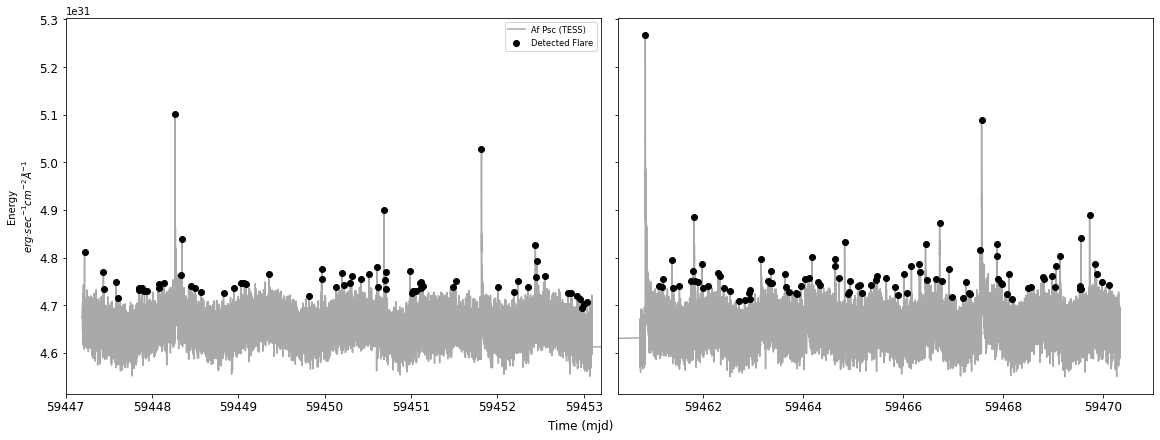

In [21]:
time_support()


t = pd.Series.tolist(curve['Time'])
time = Time(t, scale='utc',)
mjdtime = time.mjd
f = pd.Series.tolist(curve['Flux'])

distance_cm = 35*3.086e+18
eff_width = 3.898e-5
energies = []
for i in f: 
    fluence = i*eff_width
    energy = (4 * np.pi * (distance_cm**2) * fluence)
    energies.append(energy*1.95829e-9) 
peak = []
for i in peakflux: 
    fluence = i*eff_width
    energy = (4 * np.pi * (distance_cm**2) * fluence)
    peak.append(energy*1.95829e-9)
    
    
labels=['Af Psc (TESS)','Detected Flare']

fig,(ax1,ax2)=plt.subplots(1,2,constrained_layout=True, figsize=(16,6),sharey=True)
ax1.plot(mjdtime,energies,zorder=0,c='darkgrey')
#ax1.set(xlabel='Time (mjd)')
ax1.set(ylabel=f'Energy\n'+r'$erg·sec^{-1}cm^{-2}Å^{-1}$')
ax1.set_xlim(59447,59453.2)
ax1.tick_params(axis='both',labelsize=12)
ax1.scatter(mjdtime[ix],peak, c='black', zorder=5, marker='o')
ax1.legend(labels=labels,loc='upper right',fontsize='small')

ax2.plot(mjdtime,energies,zorder=0,c='darkgrey')
fig.supxlabel('Time (mjd)')
ax2.set_xlim(59460.3,59471)
ax2.tick_params(axis='both',labelsize=12)
ax2.scatter(mjdtime[ix],peak, c='black', zorder=5, marker='o')

#plt.savefig('Final_DetectedFlares',dpi=500, bbox_inches="tight", pad_inches=0)

In [22]:
times[flare_ranges[0][67]].index

Int64Index([25930, 25931, 25932, 25933, 25934, 25935, 25936, 25937, 25938,
            25939,
            ...
            26204, 26205, 26206, 26207, 26208, 26209, 26210, 26211, 26212,
            26213],
           dtype='int64', length=284)

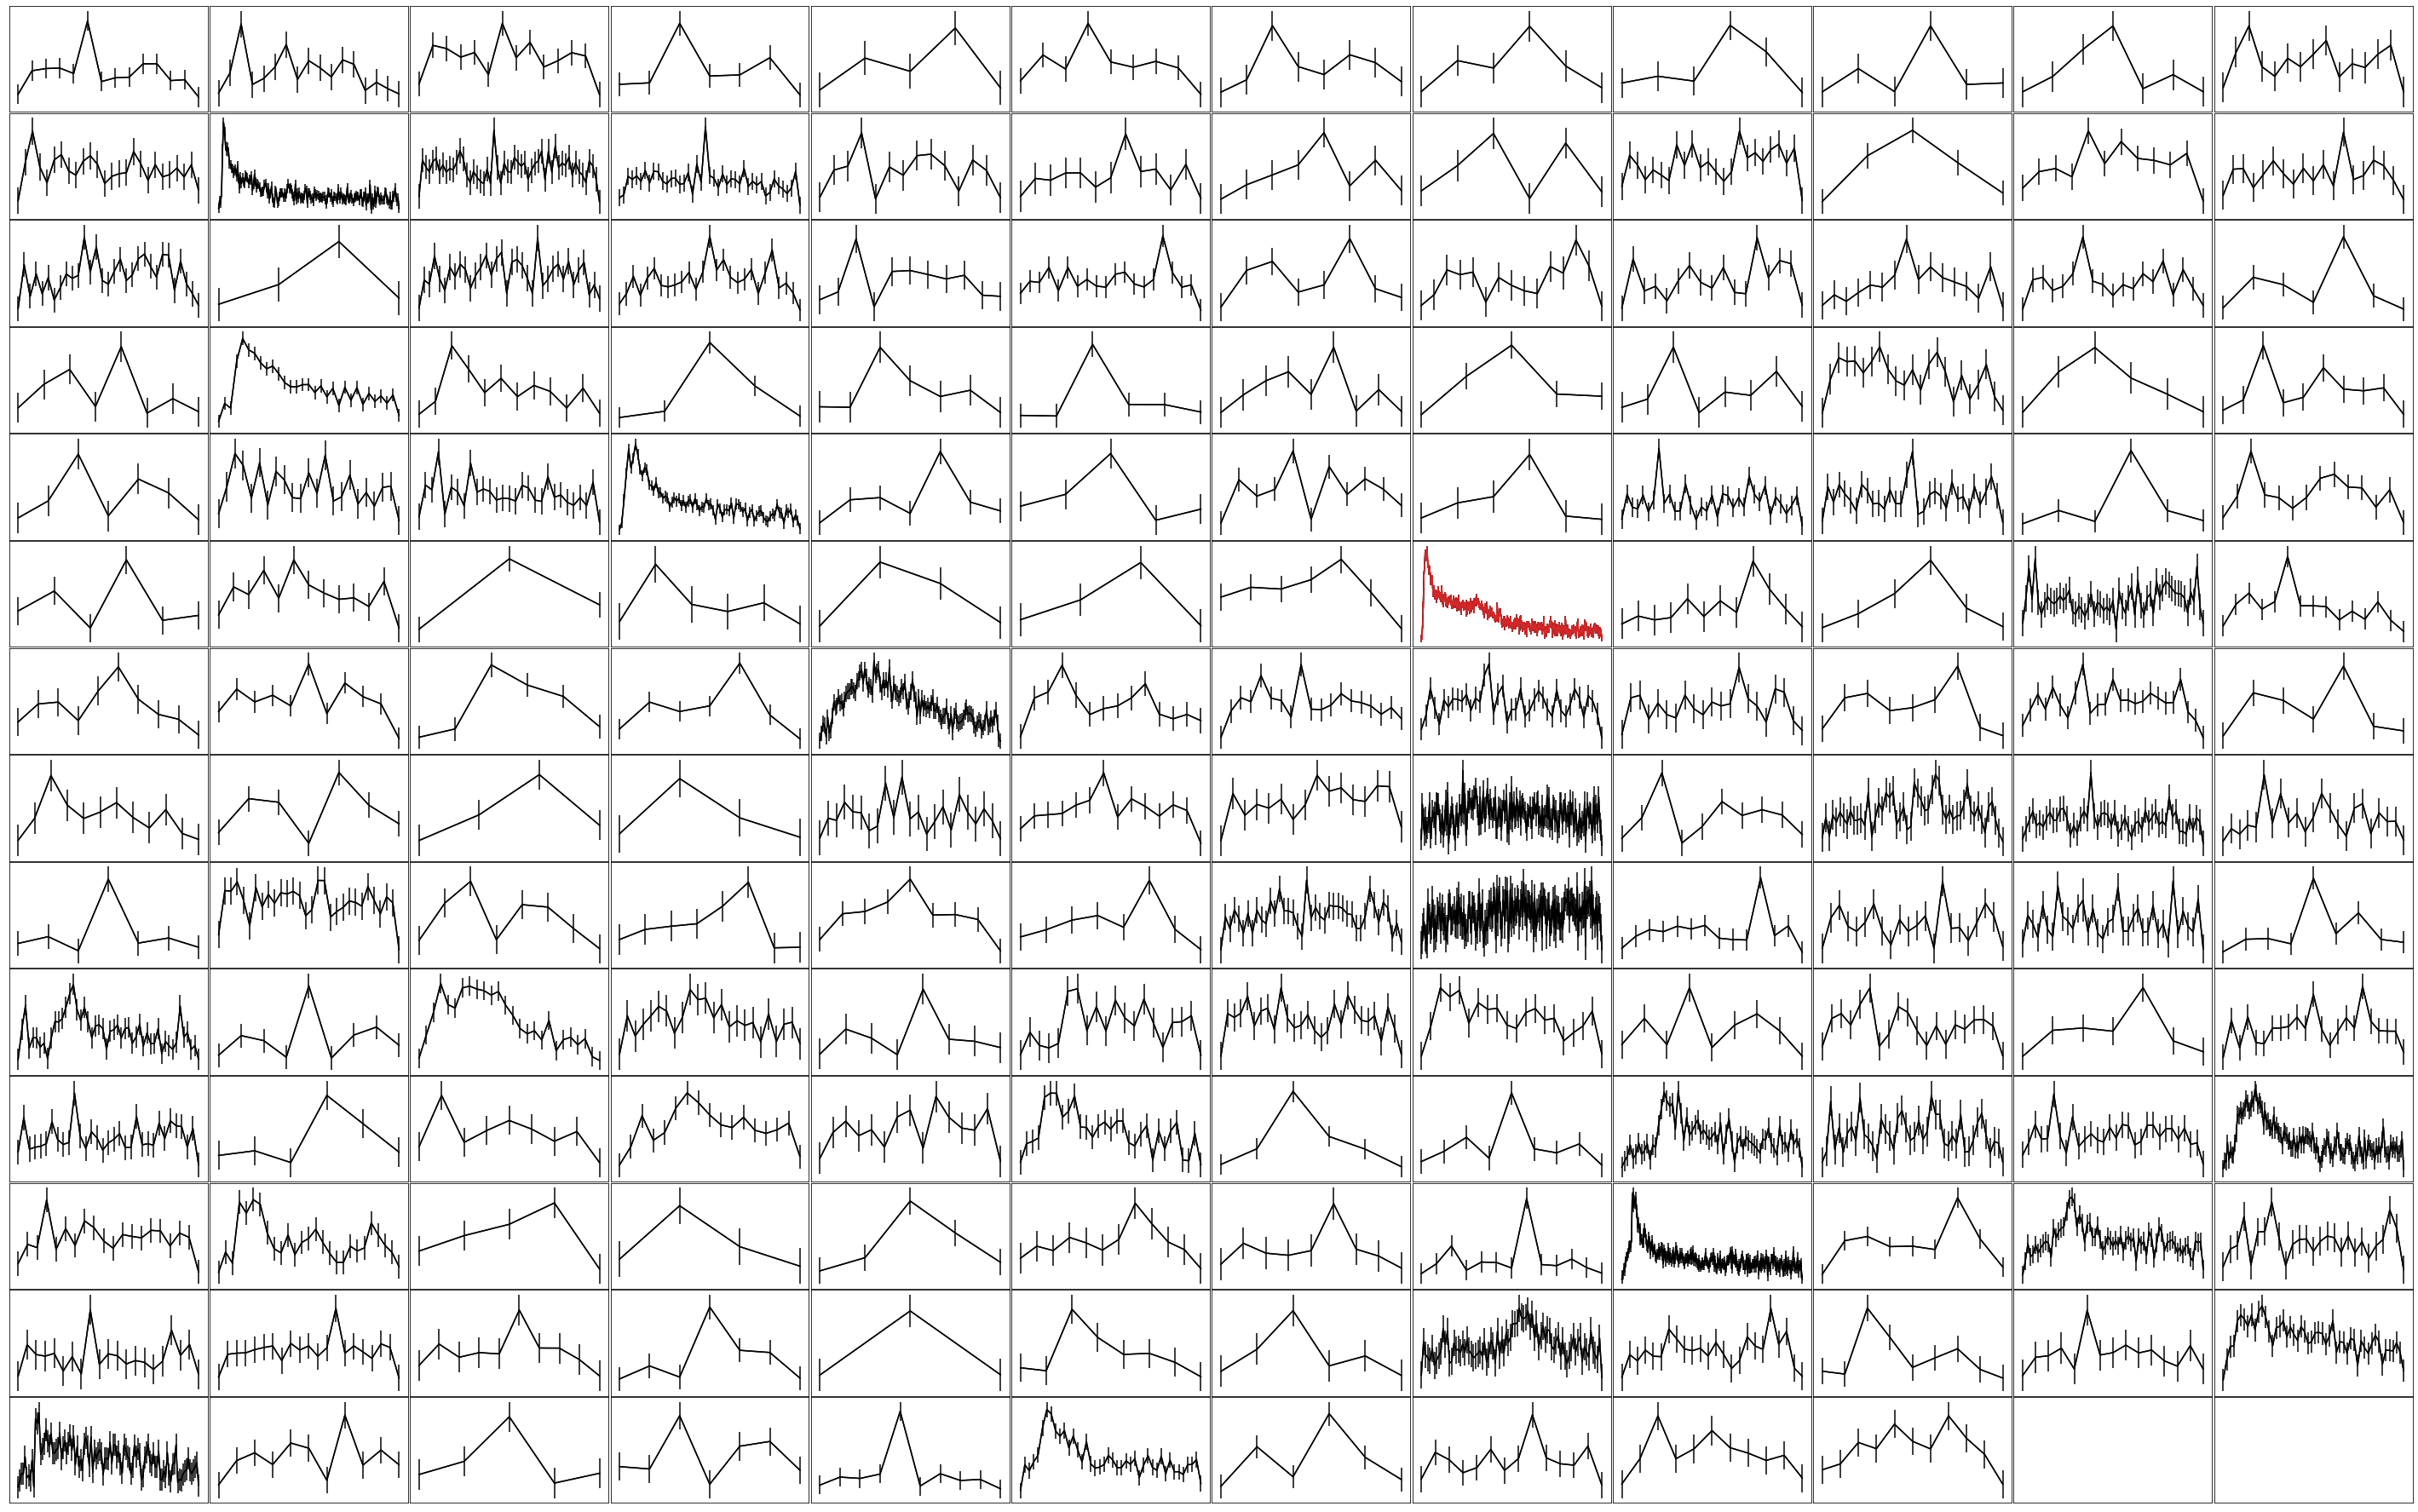

In [23]:
fig,ax = plt.subplots(14,12)
fig.set_size_inches(40,25)
fig.tight_layout()
for i,v in enumerate(flare_ranges[0]):
    t = (times[v])
    f = (fluxes[v])
    y_er = (err[v])
    quies = (q[v])
    #ax.flat[i].plot(quies,color='black')
    ax.flat[i].plot(f,color='black')
    ax.flat[i].errorbar(t.index,f.values,yerr=y_er,color='black')
    plt.setp(ax, xticks=[], yticks=[])
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    #clearing out time/flux ticks for now to make graphs easier to look at
    #ax.flat[i].set_title(i)
ax[5,7].errorbar(times[flare_ranges[0][67]].index,fluxes[flare_ranges[0][67]],yerr=err[flare_ranges[0][67]],color='tab:red',zorder=10)
plt.show()
#fig.savefig('final_big_grid_o_flares', dpi=300, bbox_inches="tight", pad_inches=0)


In [24]:
tess_time = curve['Time']

In [25]:
#Adapted from Fleming et al 2022

#Calculate on-source time
#chunk 1: between TESS start observation time and first cutoff (2021-08-27 02:19:12.359)
#chunk 2: between 2021-09-03 17:52:28.664 and end of TESS observation time 
t1=tess_time[25489]-tess_time[0] #days
t2=tess_time[66883]-tess_time[25460] #days
ontimesec=(t1+t2)*24*60*60
ontimemin=ontimesec/60
ontimehour=ontimemin/60
print('Total Time on Source:',t1+t2,'days')
print('Total Time on Source:',ontimehour,'hours')
print('Total TIme on Source:',ontimemin,'minutes')
print('Total Time on Source:',ontimesec,'seconds')

Total Time on Source: 23.1474527195096 days
Total Time on Source: 555.5388652682304 hours
Total TIme on Source: 33332.331916093826 minutes
Total Time on Source: 1999939.9149656296 seconds


In [26]:
#Adapted from Fleming et al 2022

#number of flares from flare finding function
n_flares=165
#set sigma for uncertainties
sigma=1
flare_rt=n_flares/33332.331916093826
flare_rt_er= np.sqrt(n_flares)/33332.331916093826
print(f'AF Psc: {flare_rt} +/- {sigma*flare_rt_er} flares per minute')
rate_ = np.log10(flare_rt*60)
rate_err = np.log10((flare_rt + sigma*flare_rt_er)*60) - np.log10(flare_rt*60)
print(f'log10(#/hr) = {rate_} +/- {rate_err}')

AF Psc: 0.004950148714927838 +/- 0.0003853685548013841 flares per minute
log10(#/hr) = -0.5272305031873609 +/- 0.032558283516892494


In [27]:

# FFD rates from Guenther et al. 2020 using TESS for mid-M dwarfs.
guenther_file = "/Users/katborski/Documents/GitHub/catalog_per_star_final.csv"
if not os.path.isfile(guenther_file):
    raise IOError("Missing FFD reference file: " + guenther_file + " from repository.")
(tic_id,_,_,_,_,_,_,_,_,_,_,_,_,teff,radius,logg,_,_,_,_,FFD_alpha,FFD_beta,_,_,_,_) = np.genfromtxt(
    guenther_file,unpack=True,dtype=float,comments='#',delimiter=',')
# We only want to plot the FFDs from their sample for stars roughly similar to M5, so let's
# use some approximate ranges for M3-M6 or so.
teff_min = 2500.
teff_max = 3250.
# We'll loop through and plot these later in the cell that makes the figure.

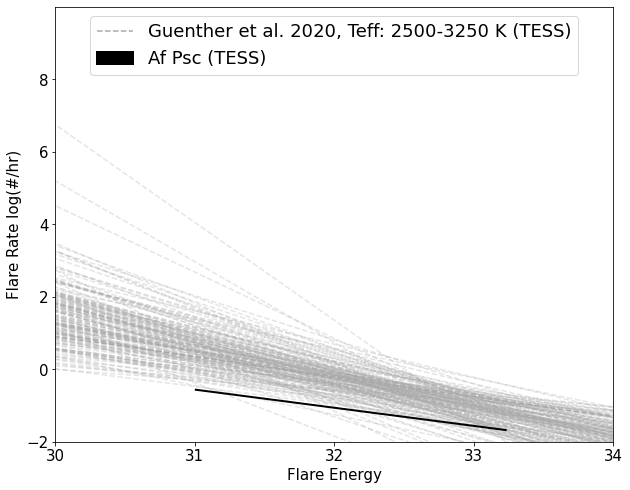

In [28]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, figsize=(10, 8))

# This is used to add some text to the plot legend...
plt.plot([], [], ' ', label=None)

# Plot the M3-M6 dwarf sample from Guenther et al.
guenther_xvals = np.linspace(28., 38., 50)
# This will make it so we only apply a label legend for this sample once.
first_guenther = False
for t,r,a,b in zip(teff,radius,FFD_alpha,FFD_beta):
    if t >= teff_min and t <= teff_max:
        these_guenther_yvals = [b + a*x for x in guenther_xvals]
        if not first_guenther:
            ax.plot(guenther_xvals, these_guenther_yvals, color='darkgrey', linestyle='dashed',
                    label="Guenther et al. 2020, Teff: {0:4.0f}-{1:4.0f} K (TESS)".format(
                        teff_min, teff_max), zorder=1)
            first_guenther = True
        else:
            ax.plot(guenther_xvals, these_guenther_yvals, color='darkgrey', linestyle='dashed', zorder=1,alpha=0.3)
            
# Plot our estimated value.
rect = Rectangle((31,rate_-rate_err), 2.5, 0, angle=-26.6, label="Af Psc (TESS)", color='black', zorder=3, fill=True, linewidth=2)
ax.add_patch(rect)
# Refine plot ranges.
ax.set_xlim([30., 34.])
ax.set_ylim([-2, 10])
ax.set_xticks([30,31,32,33,34])
ax.set_yticks([-2,0,2,4,6,8])
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel("Flare Energy",fontsize=15)
ax.set_ylabel("Flare Rate log(#/hr)",fontsize=15)
lgd = ax.legend(loc="upper center",ncol=1)
#fig.savefig('draft_poster_FFD', dpi=500, bbox_inches="tight", pad_inches=0)

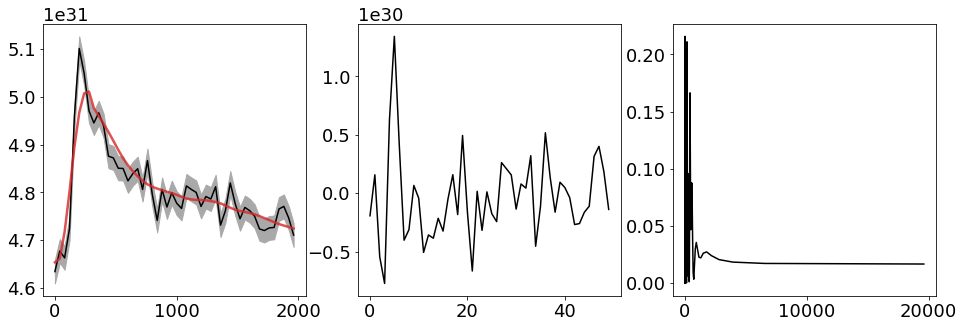

In [29]:
# QPP 1: Flare 13

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][13][0:50]]
timesec = np.arange(0,len(flare_ranges[0][13]),1)*40
flareflux = fluxes[flare_ranges[0][13]]
flare_er = err[flare_ranges[0][13]]
qpp_1 = timesec[0:50], pd.Series.to_numpy(flareflux)[0:50], pd.Series.to_numpy(flare_er)[0:50]
ergs = []
er = []
for i in qpp_1[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs.append(energy*1.95829e-9)
for x in qpp_1[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = (energy*1.95829e-9)
    er.append(en_err)
    
#fit/plot: boxcar

rise = ergs[0:5]
decay = ergs[5:50]

rise_kernel = Box1DKernel(5,mode='center')
decay_kernel = Box1DKernel(16,mode='center')
smooth_rise = convolve(rise, rise_kernel, boundary='extend')
smooth_decay = convolve(decay, decay_kernel, boundary='extend')

fit = np.concatenate((smooth_rise,smooth_decay))
fit1 = sig.savgol_filter(fit,7,3)

ax1.plot(qpp_1[0],ergs,c='black')
ax1.fill_between(qpp_1[0],np.array(ergs)-np.array(er),np.array(ergs)+np.array(er),color='darkgrey')
ax1.plot(qpp_1[0],fit1,color='tab:red',linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_1 = ergs-fit1
ax2.plot(range(len(res_1)),res_1,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_1[0], res_1)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02,samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')

Scipy Period:4.545454545454546sec
Welch Period:4.545454545454546sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/544196106.py:4: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/544196106.py:7: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


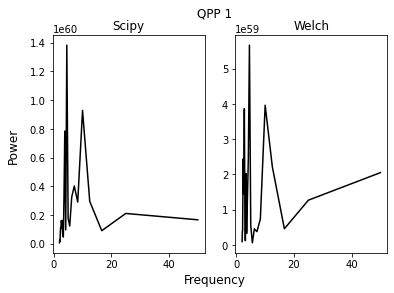

In [146]:
fig,(ax1,ax2) = plt.subplots(1,2)

sci_f,sci_p = sig.periodogram(res_1)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_1)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 1')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

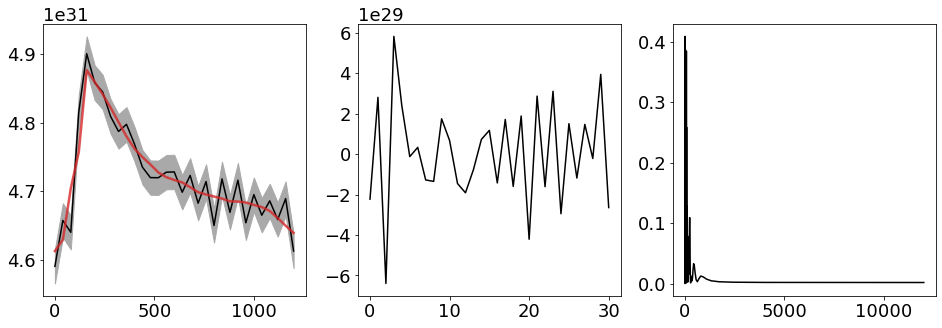

In [31]:
#QPP 2: Flare 37

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][37]]
timesec = np.arange(0,len(flare_ranges[0][37]),1)*40
flareflux = fluxes[flare_ranges[0][37]]
flare_er = err[flare_ranges[0][37]]
qpp_2 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs2 = []
er2 = []
for i in qpp_2[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs2.append(energy*1.95829e-9)
for x in qpp_2[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er2.append(en_err)
    
#fit/plot: boxcar

rise2= ergs2[0:4]
decay2 = ergs2[4:31]

rise_kernel2 = Box1DKernel(3,mode='center')
decay_kernel2 = Box1DKernel(6,mode='center')

smooth_rise2 = convolve(rise2, rise_kernel2, boundary='extend')
smooth_decay2 = convolve(decay2, decay_kernel2, boundary='extend')

fit2 = np.concatenate((smooth_rise2,smooth_decay2))


ax1.plot(qpp_2[0],ergs2,c='black')
ax1.fill_between(qpp_2[0],np.array(ergs2)-np.array(er2),np.array(ergs2)+np.array(er2),color='darkgrey')
ax1.plot(qpp_2[0],fit2,color='tab:red',linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_2 = ergs2-fit2
ax2.plot(range(len(res_2)),res_2,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_2[0], res_2)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02,samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')

Scipy Period:2.2142857142857144sec
Welch Period:2.0666666666666664sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2624199330.py:4: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2624199330.py:7: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


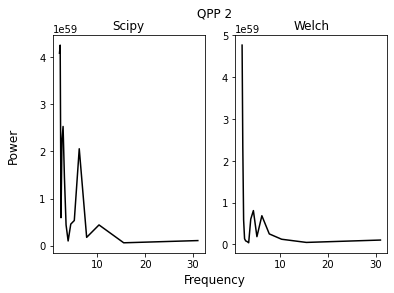

In [147]:
fig,(ax1,ax2) = plt.subplots(1,2)

sci_f,sci_p = sig.periodogram(res_2)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_2)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 2')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

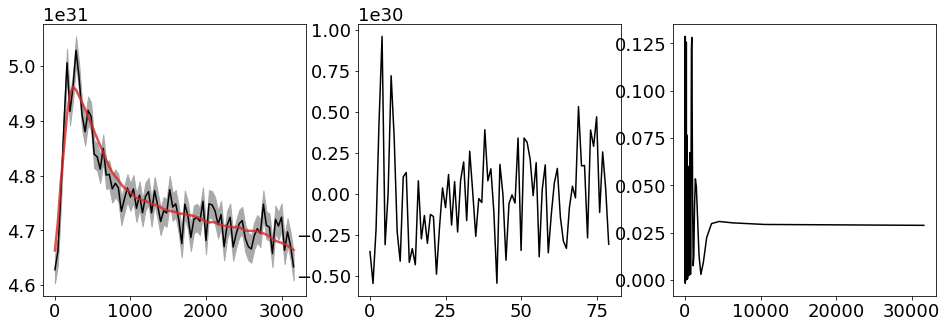

In [33]:
#QPP 3: Flare 51

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][51]]
timesec = np.arange(0,len(flare_ranges[0][51]),1)*40
flareflux = fluxes[flare_ranges[0][51]]
flare_er = err[flare_ranges[0][51]]
qpp_3 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs3 = []
er3 = []
for i in qpp_3[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs3.append(energy*1.95829e-9)
for x in qpp_3[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er3.append(en_err)
#fit/plot: boxcar

rise3 = ergs3[0:7]
decay3 = ergs3[7:80]

rise_kernel3 = Box1DKernel(5,mode='oversample')
decay_kernel3 = Box1DKernel(20,mode='oversample')
smooth_rise3 = convolve(rise3, rise_kernel3, boundary='extend')
smooth_decay3 = convolve(decay3, decay_kernel3, boundary='extend')

fit3 = np.concatenate((smooth_rise3,smooth_decay3))
ax1.plot(qpp_3[0],ergs3,c='black')
ax1.fill_between(qpp_3[0],np.array(ergs3)-np.array(er3),np.array(ergs3)+np.array(er3),color='darkgrey')
ax1.plot(qpp_3[0],fit3,color='tab:red',linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_3 = ergs3-fit3
ax2.plot(range(len(res_3)),res_3,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_3[0], res_3)
freq, powr = ls_period.autopower()#minimum_frequency=0.01,maximum_frequency=0.02,samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')

Scipy Period:4.444444444444445sec
Welch Period:2.5sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1457161100.py:4: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1457161100.py:7: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


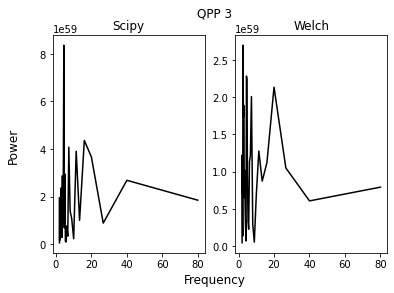

In [85]:
fig,(ax1,ax2) = plt.subplots(1,2)

sci_f,sci_p = sig.periodogram(res_3)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_3)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 3')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

Text(0, 0.5, 'Power')

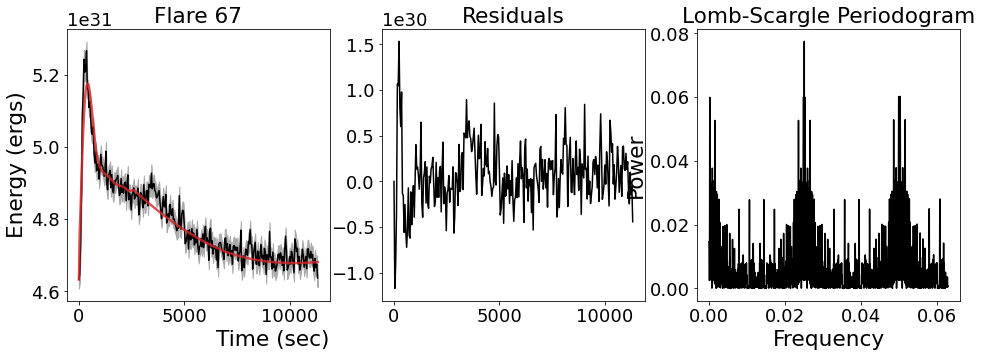

In [35]:
#QPP 4: Flare 67

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][67]]
timesec = np.arange(0,len(flare_ranges[0][67]),1)*40
flareflux = fluxes[flare_ranges[0][67]]
flare_er = err[flare_ranges[0][67]]
qpp_4 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs4 = []
er4 = []
for i in qpp_4[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs4.append(energy*1.95829e-9)
for x in qpp_4[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er4.append(en_err)

#fit/plot: savgol & boxcar

fit004 = sig.savgol_filter(ergs4[0:62],31,3)
fit04 = sig.savgol_filter(ergs4[62:284],219,3)-1e29
fit4 = np.concatenate((fit004,fit04))
box_kernel = Box1DKernel(5)
smooth_4_1 = convolve(fit4, box_kernel, boundary='extend')
smooth_4_2 = convolve(smooth_4_1, box_kernel, boundary='extend')
smooth_4_2[0] = ergs4[0]

ax1.plot(qpp_4[0],ergs4,c='black')
ax1.set_title('Flare 67')
ax1.set_xlabel('Time (sec)',fontsize='large',loc='right')
ax1.set_ylabel('Energy (ergs)',fontsize='large')
ax1.fill_between(qpp_4[0],np.array(ergs4)-np.array(er4),np.array(ergs4)+np.array(er4),color='darkgrey')
ax1.plot(qpp_4[0],smooth_4_2,color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_4 = ergs4-smooth_4_2
residual4 = []
for i,v in enumerate(res_4): 
    x = i*40
    residual4.append(x)
ax2.set_title('Residuals')
ax2.plot(residual4,res_4,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_4[0], res_4)
freq, powr = ls_period.autopower()#minimum_frequency=0.01,maximum_frequency=0.1,samples_per_peak=20)
ax3.set_title('Lomb-Scargle Periodogram')
ax3.plot(freq,powr,c='black')
ax3.set_xlabel('Frequency',fontsize='large')
ax3.set_ylabel('Power',fontsize='large')
#fig.savefig('final_Flare67.png',dpi=500)

In [36]:
frequency = np.asarray(freq)
power = np.asarray(powr)

print("Max Period = " + str(1./frequency[np.argmax(power)]) + " sec" +
         " with False Alarm Probability = " +
      str(ls_period.false_alarm_probability(power.max())))


Max Period = 39.985870717061104 sec with False Alarm Probability = 0.029624772486393326


Scipy Period:142.0sec
Welch Period:128.0sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1344167463.py:4: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1344167463.py:7: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


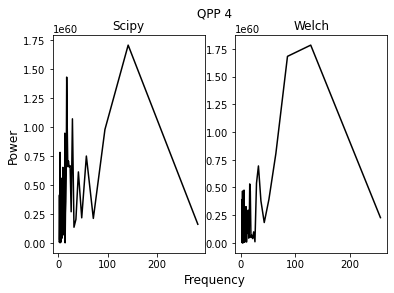

In [81]:
fig,(ax1,ax2) = plt.subplots(1,2)

sci_f,sci_p = sig.periodogram(res_4)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_4)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 4')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

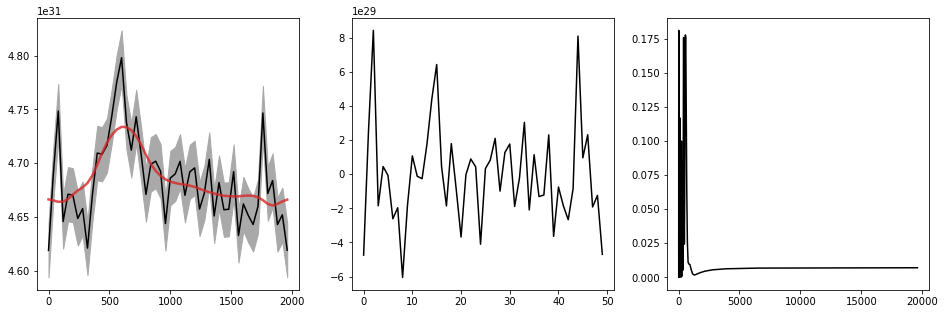

In [120]:
#QPP 5: Flare 108

# False QPP 


fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][108]]
timesec = np.arange(0,len(flare_ranges[0][108]),1)*40
flareflux = fluxes[flare_ranges[0][108]]
flare_er = err[flare_ranges[0][108]]
qpp_5 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs5=[]
er5=[]
for i in qpp_5[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs5.append(energy*1.95829e-9)
for x in qpp_5[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er5.append(en_err)
#fit/plot: savgol & boxcar

fit0005 = sig.savgol_filter(ergs5[0:15],11,3)
#fit005 = sig.savgol_filter(ergs5[10:25],7,3)
fit05 = sig.savgol_filter(ergs5[15:50],21,3)
fit5 = np.concatenate((fit0005,fit05))
box_kernel = Box1DKernel(10)
smooth_5_1 = convolve(fit5, box_kernel, boundary='wrap')
smooth_5_2 = convolve(smooth_5_1, box_kernel, boundary='wrap')

ax1.plot(qpp_5[0],ergs5,c='black')
ax1.fill_between(qpp_5[0],np.array(ergs5)-np.array(er5),np.array(ergs5)+np.array(er5),color='darkgrey')
ax1.plot(qpp_5[0],smooth_5_1,color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)


#get/plot residuals 
res_5 = ergs5-smooth_5_1
ax2.plot(range(len(res_5)),res_5,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_5[0], res_5)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.1, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2625053366.py:11: RuntimeWarning: divide by zero encountered in divide
  ax3.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 35, using nperseg = 35
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2625053366.py:14: RuntimeWarning: divide by zero encountered in divide
  ax4.plot(1./wel_f,wel_p,c='black')


Scipy Period:2.9166666666666665sec
Welch Period:2.692307692307692sec


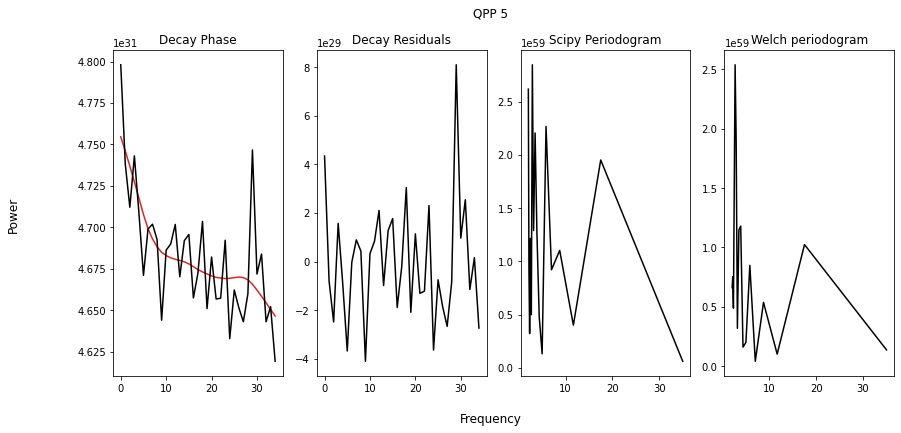

In [145]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(14,6))
bf = Box1DKernel(10)
decay5 = convolve(fit05,bf,boundary='extend')
ax1.plot(range(len(decay5)),decay5,c='tab:red')
ax1.set_title('Decay Phase')
ax1.plot(range(len(ergs5[15:50])),ergs5[15:50],c='black')
res_5 = ergs5[15:50]-decay5
ax2.plot(range(len(res_5)),res_5,c='black')
ax2.set_title('Decay Residuals')
sci_f,sci_p = sig.periodogram(res_5)
ax3.plot(1./sci_f,sci_p,c='black')
ax3.set_title('Scipy Periodogram')
wel_f,wel_p = sig.welch(res_5)
ax4.plot(1./wel_f,wel_p,c='black')
ax4.set_title('Welch periodogram')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 5')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')


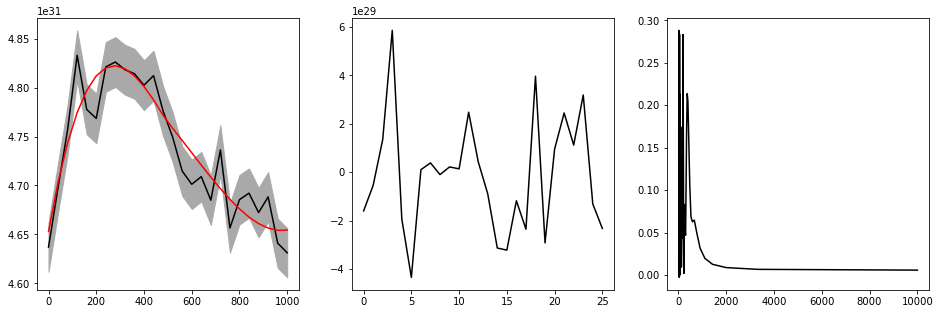

In [148]:
#QPP 6: Flare 110 FALSE

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][110]]
timesec = np.arange(0,len(flare_ranges[0][110]),1)*40
flareflux = fluxes[flare_ranges[0][110]]
flare_er = err[flare_ranges[0][110]]
qpp_6 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs6 = []
er6 = []
for i in qpp_6[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs6.append(energy*1.95829e-9)
for x in qpp_6[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er6.append(en_err)


#fit/plot: savgol

fit006 = sig.savgol_filter(ergs6,23,3)

ax1.plot(qpp_6[0],ergs6,c='black')
ax1.fill_between(qpp_6[0],np.array(ergs6)-np.array(er6),np.array(ergs6)+np.array(er6),color='darkgrey')
ax1.plot(qpp_6[0],fit006,c='r',zorder=10)

#get/plot residuals 
res_6 = ergs6-fit006
ax2.plot(range(len(res_6)),res_6,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_6[0], res_6)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:5.199999999999999sec
Welch Period:8.666666666666666sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3908894815.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3908894815.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


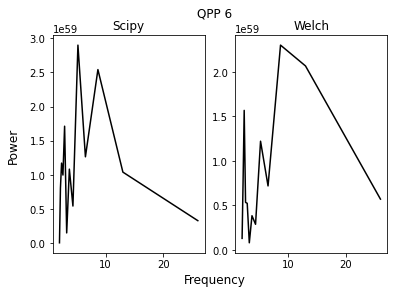

In [152]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_6)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_6)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 6')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

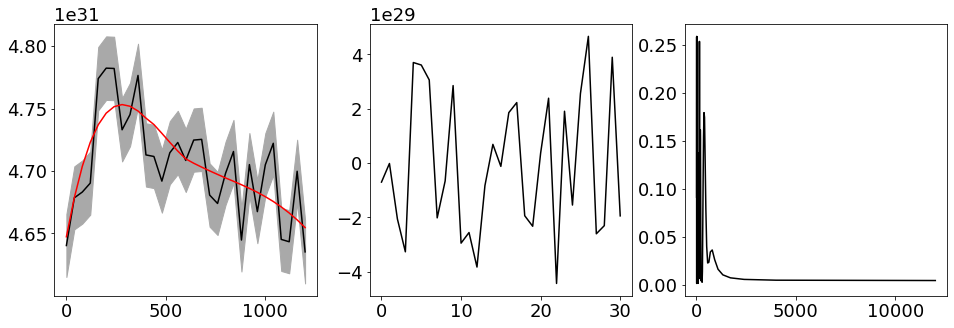

In [45]:
#QPP 7: Flare 125

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][125]]
timesec = np.arange(0,len(flare_ranges[0][125]),1)*40
flareflux = fluxes[flare_ranges[0][125]]
flare_er = err[flare_ranges[0][125]]
qpp_7 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs7 = []
er7 = []
for i in qpp_7[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs7.append(energy*1.95829e-9)
for x in qpp_7[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er7.append(en_err)

#fit/plot: boxcar

rise7= ergs7[0:5]
decay7 = ergs7[5:31]

rise_kernel7 = Box1DKernel(5,mode='center')
decay_kernel7 = Box1DKernel(10,mode='center')

smooth_rise7 = convolve(rise7, rise_kernel7, boundary='extend')
smooth_decay7 = convolve(decay7, decay_kernel7, boundary='extend')


fit7 = np.concatenate((smooth_rise7,smooth_decay7))
fit7_1 = sig.savgol_filter(fit7,21,3)

ax1.plot(qpp_7[0],ergs7,c='black')
ax1.fill_between(qpp_7[0],np.array(ergs7)-np.array(er7),np.array(ergs7)+np.array(er7),color='darkgrey')
ax1.plot(qpp_7[0],fit7_1,c='r',zorder=10)

#get/plot residuals 
res_7 = ergs7-fit7_1
ax2.plot(range(len(res_7)),res_7,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_7[0], res_7)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:10.333333333333334sec
Welch Period:10.333333333333334sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/150818426.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/150818426.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


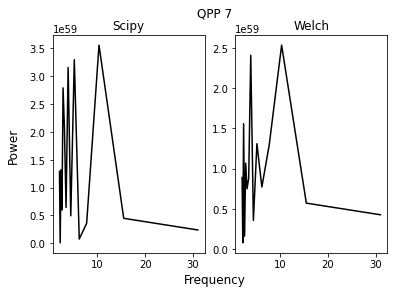

In [155]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_7)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_7)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 7')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

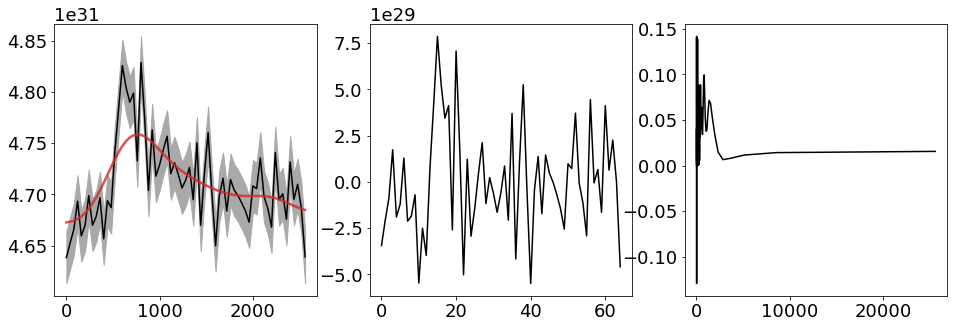

In [47]:
###needs decay phase analysis

#QPP 8: Flare 128

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][128]]
timesec = np.arange(0,len(flare_ranges[0][128]),1)*40
flareflux = fluxes[flare_ranges[0][128]]
flare_er = err[flare_ranges[0][128]]
qpp_8 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs8 = []
er8 = []
for i in qpp_8[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs8.append(energy*1.95829e-9)
for x in qpp_8[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er8.append(en_err)

#fit/plot: savgol & boxcar

fit008 = sig.savgol_filter(ergs8,21,5)
box_kernel = Box1DKernel(10)
smooth_8_1 = convolve(fit008, box_kernel, boundary='wrap')
smooth_8_2 = convolve(smooth_8_1, box_kernel, boundary='extend')
smooth_8_3 = convolve(smooth_8_2, box_kernel, boundary='extend')

ax1.plot(qpp_8[0],ergs8,c='black')
ax1.fill_between(qpp_8[0],np.array(ergs8)-np.array(er8),np.array(ergs8)+np.array(er8),color='darkgrey')
ax1.plot(qpp_8[0],smooth_8_3,color='tab:red',zorder=10,alpha=0.8,linewidth=2.5)

#get/plot residuals 
res_8 = ergs8-smooth_8_3
ax2.plot(range(len(res_8)),res_8,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_8[0], res_8)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:2.9545454545454546sec
Welch Period:2.9545454545454546sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3242862264.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 65, using nperseg = 65
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3242862264.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


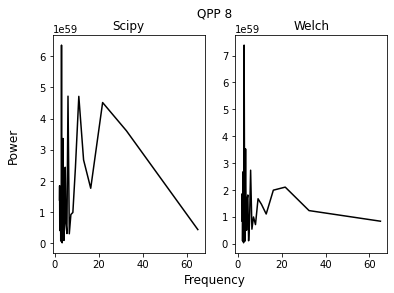

In [156]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_8)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_8)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 8')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

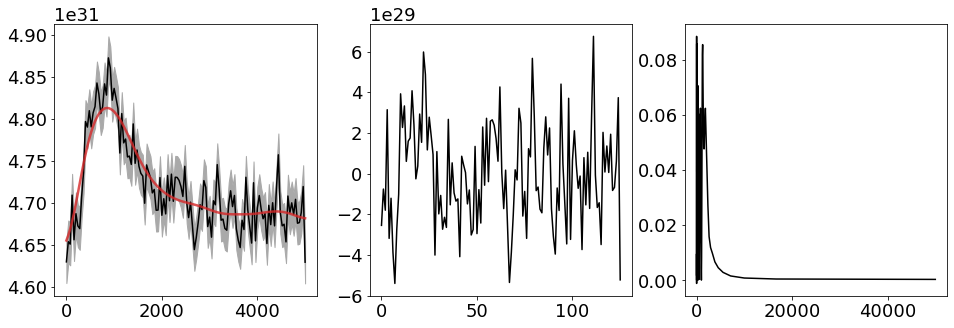

In [49]:
#QPP 9: Flare 131

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][131]]
timesec = np.arange(0,len(flare_ranges[0][131]),1)*40
flareflux = fluxes[flare_ranges[0][131]]
flare_er = err[flare_ranges[0][131]]
qpp_9 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs9 = []
er9 = []
for i in qpp_9[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs9.append(energy*1.95829e-9)
for x in qpp_9[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er9.append(en_err)

#fit/plot: savgol & boxcar

fit009 = sig.savgol_filter(ergs9,51,3)
box_kernel = Box1DKernel(10)
smooth_9_1 = convolve(fit009, box_kernel, boundary='extend')
smooth_9_2 = convolve(smooth_9_1, box_kernel, boundary='extend')
smooth_9_3 = convolve(smooth_9_2, box_kernel, boundary='extend')

ax1.plot(qpp_9[0],ergs9,c='black')
ax1.fill_between(qpp_9[0],np.array(ergs9)-np.array(er9),np.array(ergs9)+np.array(er9),color='darkgrey')
ax1.plot(qpp_9[0],smooth_9_3,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_9 = ergs9-smooth_9_3
ax2.plot(range(len(res_9)),res_9,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_9[0], res_9)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=2)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:31.5sec
Welch Period:18.0sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3270918227.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 126, using nperseg = 126
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3270918227.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


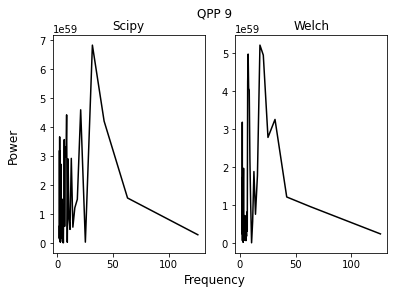

In [157]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_9)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_9)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 9')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

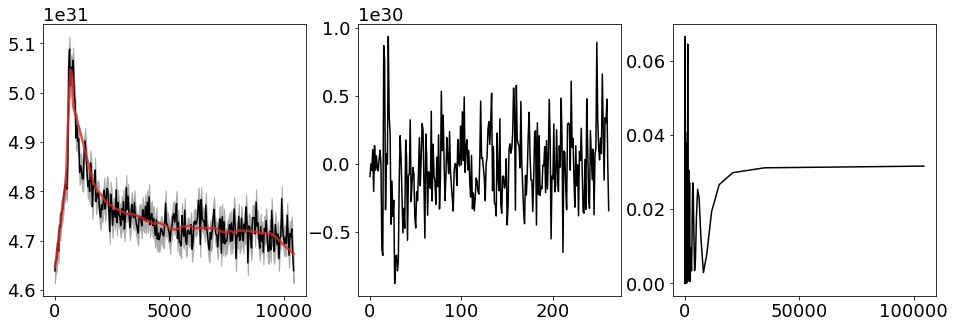

In [51]:
#QPP 10: Flare 140

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][140]]
timesec = np.arange(0,len(flare_ranges[0][140]),1)*40
flareflux = fluxes[flare_ranges[0][140]]
flare_er = err[flare_ranges[0][140]]
qpp_10 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs10 = []
er10 = []
for i in qpp_10[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs10.append(energy*1.95829e-9)
for x in qpp_10[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er10.append(en_err)

#fit/plot: boxcar

rise10 = ergs10[0:20]
decay10 = ergs10[20:262]

rise_kernel10 = Box1DKernel(5,mode='center')
decay_kernel10 = Box1DKernel(40,mode='center')
smooth_rise10 = convolve(rise10, rise_kernel10, boundary='extend')
smooth_decay10 = convolve(decay10, decay_kernel10, boundary='extend')

fit10 = np.concatenate((smooth_rise10,smooth_decay10))

ax1.plot(qpp_10[0],ergs10,c='black')
ax1.fill_between(qpp_10[0],np.array(ergs10)-np.array(er10),np.array(ergs10)+np.array(er10),color='darkgrey')
ax1.plot(qpp_10[0],fit10,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_10 = ergs10-fit10
ax2.plot(range(len(res_10)),res_10,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_10[0], res_10)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:29.11111111111111sec
Welch Period:28.444444444444443sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2759437395.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2759437395.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


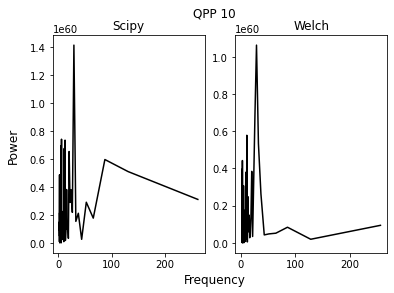

In [160]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_10)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_10)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 10')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

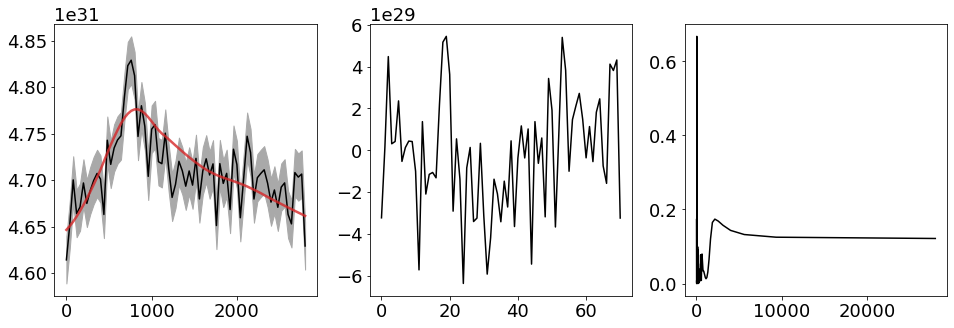

In [53]:
#QPP 11: Flare 142

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][142]]
timesec = np.arange(0,len(flare_ranges[0][142]),1)*40
flareflux = fluxes[flare_ranges[0][142]]
flare_er = err[flare_ranges[0][142]]
qpp_11 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs11 = []
er11 = []
for i in qpp_11[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs11.append(energy*1.95829e-9)
for x in qpp_11[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er11.append(en_err)
#fit/plot: boxcar & savgol 

rise11 = ergs11[0:19]
decay11 = ergs11[19:71]

rise_kernel11 = Box1DKernel(10,mode='center')
decay_kernel11 = Box1DKernel(39,mode='center')

smooth_rise11 = convolve(rise11, rise_kernel11, boundary='extend')
smooth_decay11 = convolve(decay11, decay_kernel11, boundary='extend')

fit11 = np.concatenate((smooth_rise11,smooth_decay11))
fit011 = sig.savgol_filter(fit11,21,3)

ax1.plot(qpp_11[0],ergs11,c='black')
ax1.fill_between(qpp_11[0],np.array(ergs11)-np.array(er11),np.array(ergs11)+np.array(er11),color='darkgrey')
ax1.plot(qpp_11[0],fit011,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_11 = ergs11-fit011
ax2.plot(range(len(res_11)),res_11,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_11[0], res_11)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:71.0sec
Welch Period:71.0sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3380217045.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 71, using nperseg = 71
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3380217045.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


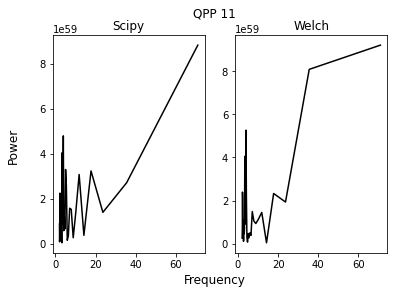

In [161]:
###needs decay phase analysis

fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_11)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_11)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 11')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

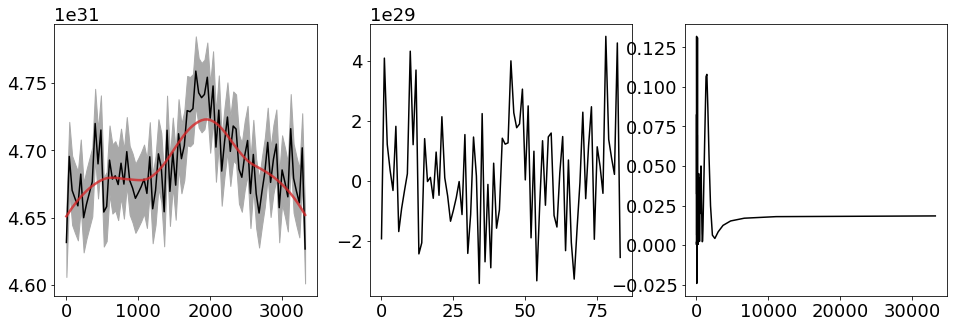

In [55]:
#QPP 12: Flare 151

#False QPP 

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][151]]
timesec = np.arange(0,len(flare_ranges[0][151]),1)*40
flareflux = fluxes[flare_ranges[0][151]]
flare_er = err[flare_ranges[0][151]]
qpp_12 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs12 = []
er12 = []
for i in qpp_12[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs12.append(energy*1.95829e-9)
for x in qpp_12[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er12.append(en_err)
#fit/plot: boxcar & savgol

box_kernel = Box1DKernel(20)
smooth_12_1 = convolve(ergs12, box_kernel, boundary='extend')
fit012 = sig.savgol_filter(smooth_12_1,21,3)

ax1.plot(qpp_12[0],ergs12,c='black')
ax1.fill_between(qpp_12[0],np.array(ergs12)-np.array(er12),np.array(ergs12)+np.array(er12),color='darkgrey')
ax1.plot(qpp_12[0],fit012,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_12 = ergs12-smooth_12_1
ax2.plot(range(len(res_12)),res_12,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_12[0], res_12)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.1, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:3.36sec
Welch Period:28.0sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1499275086.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 84, using nperseg = 84
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/1499275086.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


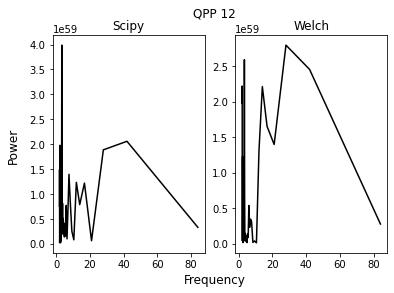

In [163]:
###re-analyze for secondary peaks in periodograms
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_12)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_12)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 12')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

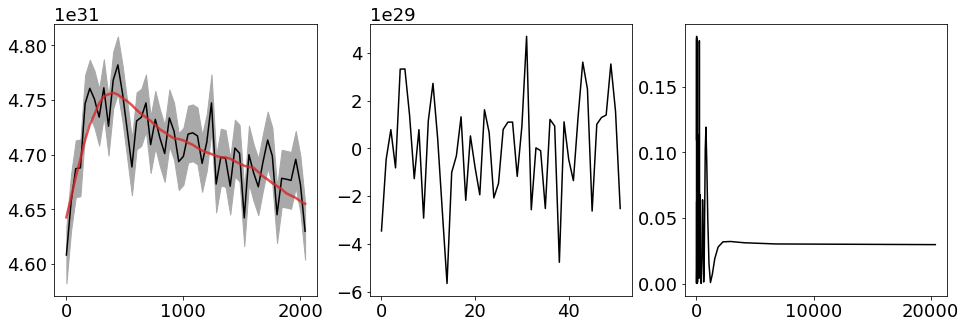

In [57]:
#QPP 13: Flare 155

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][155]]
timesec = np.arange(0,len(flare_ranges[0][155]),1)*40
flareflux = fluxes[flare_ranges[0][155]]
flare_er = err[flare_ranges[0][155]]
qpp_13 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs13 = []
er13 = []
for i in qpp_13[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs13.append(energy*1.95829e-9)
for x in qpp_13[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er13.append(en_err)
#fit/plot: boxcar

rise13 = ergs13[0:11]
decay13 = ergs13[11:52]

rise_kernel13 = Box1DKernel(8,mode='center')
decay_kernel13 = Box1DKernel(20,mode='center')

smooth_rise13 = convolve(rise13, rise_kernel13, boundary='extend')
smooth_decay13 = convolve(decay13, decay_kernel13, boundary='extend')

fit13 = np.concatenate((smooth_rise13,smooth_decay13))

ax1.plot(qpp_13[0],ergs13,c='black')
ax1.fill_between(qpp_13[0],np.array(ergs13)-np.array(er13),np.array(ergs13)+np.array(er13),color='darkgrey')
ax1.plot(qpp_13[0],fit13,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_13 = ergs13-fit13
ax2.plot(range(len(res_13)),res_13,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_13[0], res_13)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:6.5sec
Welch Period:2.888888888888889sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/608959114.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 52, using nperseg = 52
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/608959114.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


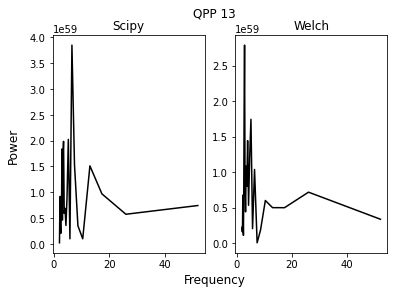

In [165]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_13)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_13)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 13')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

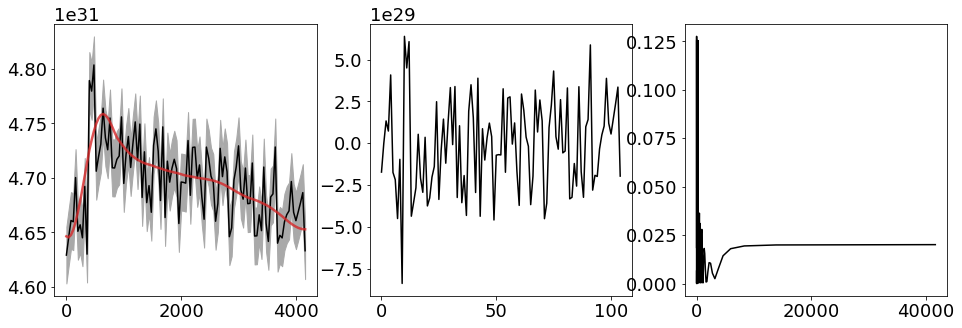

In [59]:
#QPP 14: Flare 156

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][156]]
timesec = np.arange(0,len(flare_ranges[0][156]),1)*40
flareflux = fluxes[flare_ranges[0][156]]
flare_er = err[flare_ranges[0][156]]
qpp_14 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs14 = []
er14 = []
for i in qpp_14[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs14.append(energy*1.95829e-9)
for x in qpp_14[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er14.append(en_err)
#fit/plot: boxcar

rise14 = ergs14[0:12]
decay14 = ergs14[12:105]

rise_kernel14 = Box1DKernel(8,mode='center')
decay_kernel14 = Box1DKernel(30,mode='center')

smooth_rise14 = convolve(rise14, rise_kernel14, boundary='extend')
smooth_decay14 = convolve(decay14, decay_kernel14, boundary='extend')

fit14 = np.concatenate((smooth_rise14,smooth_decay14))
fit014 = sig.savgol_filter(fit14,21,3)

ax1.plot(qpp_14[0],ergs14,c='black')
ax1.fill_between(qpp_14[0],np.array(ergs14)-np.array(er14),np.array(ergs14)+np.array(er14),color='darkgrey')
ax1.plot(qpp_14[0],fit014,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_14 = ergs14-fit014
ax2.plot(range(len(res_14)),res_14,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_14[0], res_14)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:5.833333333333333sec
Welch Period:2.8378378378378377sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2745762153.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 105, using nperseg = 105
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/2745762153.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


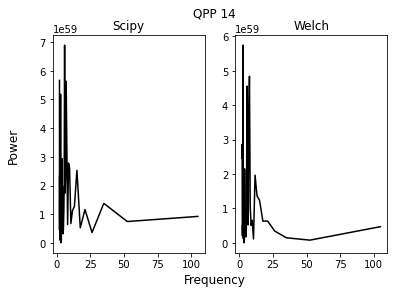

In [166]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_14)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_14)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 14')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

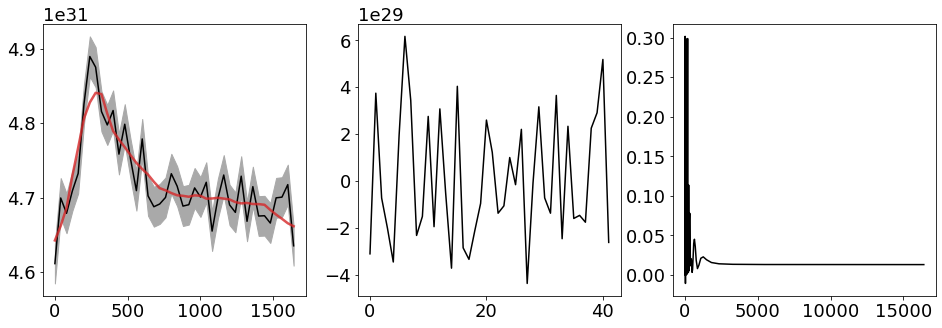

In [61]:
#QPP 15: Flare 161

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

#Create QPP dataset
qpp_time = mjdtime[flare_ranges[0][161]]
timesec = np.arange(0,len(flare_ranges[0][161]),1)*40
flareflux = fluxes[flare_ranges[0][161]]
flare_er = err[flare_ranges[0][161]]
qpp_15 = timesec, pd.Series.to_numpy(flareflux), pd.Series.to_numpy(flare_er)
ergs15 = []
er15 = []
for i in qpp_15[1]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (i*3.898e-5 ))
    ergs15.append(energy*1.95829e-9)
for x in qpp_15[2]:
    energy = (4 * np.pi * ((35*3.086e+18)**2) * (x*3.898e-5 ))
    en_err = energy*1.95829e-9
    er15.append(en_err)
#fit/plot: boxcar

rise15 = ergs15[0:12]
decay15 = ergs15[12:42]

rise_kernel15 = Box1DKernel(5,mode='center')
decay_kernel15 = Box1DKernel(10,mode='center')

smooth_rise15 = convolve(rise15, rise_kernel15, boundary='extend')
smooth_decay15 = convolve(decay15, decay_kernel15, boundary='extend')
fit15 = np.concatenate((smooth_rise15,smooth_decay15))

ax1.errorbar(qpp_15[0],ergs15,c='black')
ax1.fill_between(qpp_15[0],np.array(ergs15)-np.array(er15),np.array(ergs15)+np.array(er15),color='darkgrey')
ax1.plot(qpp_15[0],fit15,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#get/plot residuals 
res_15 = ergs15-fit15
ax2.plot(range(len(res_15)),res_15,c='black')

#create/plot periodogrgam
ls_period = LombScargle(qpp_15[0], res_15)
freq, powr = ls_period.autopower()#minimum_frequency=0.01, maximum_frequency=0.02, samples_per_peak=20)
ax3.plot(1./freq,powr,c='black')  

Scipy Period:4.666666666666667sec
Welch Period:2.8000000000000003sec


/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3242092740.py:3: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(1./sci_f,sci_p,c='black')
/Users/katborski/opt/anaconda3/envs/tess_swift_afpsc/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 42, using nperseg = 42
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_41971/3242092740.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./wel_f,wel_p,c='black')


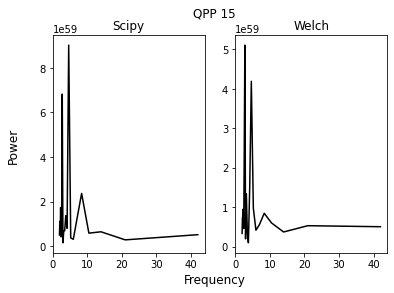

In [167]:
fig,(ax1,ax2) = plt.subplots(1,2)
sci_f,sci_p = sig.periodogram(res_15)
ax1.plot(1./sci_f,sci_p,c='black')
ax1.set_title('Scipy')
wel_f,wel_p = sig.welch(res_15)
ax2.plot(1./wel_f,wel_p,c='black')
ax2.set_title('Welch')
fig.supxlabel('Frequency')
fig.supylabel('Power')
fig.suptitle('QPP 15')

print('Scipy Period:'+ str(1./sci_f[np.argmax(sci_p)]) + 'sec\n'
      'Welch Period:'+str(1./wel_f[np.argmax(wel_p)]) + 'sec')

Text(0.5, 0.01, 'Seconds (from flare start )')

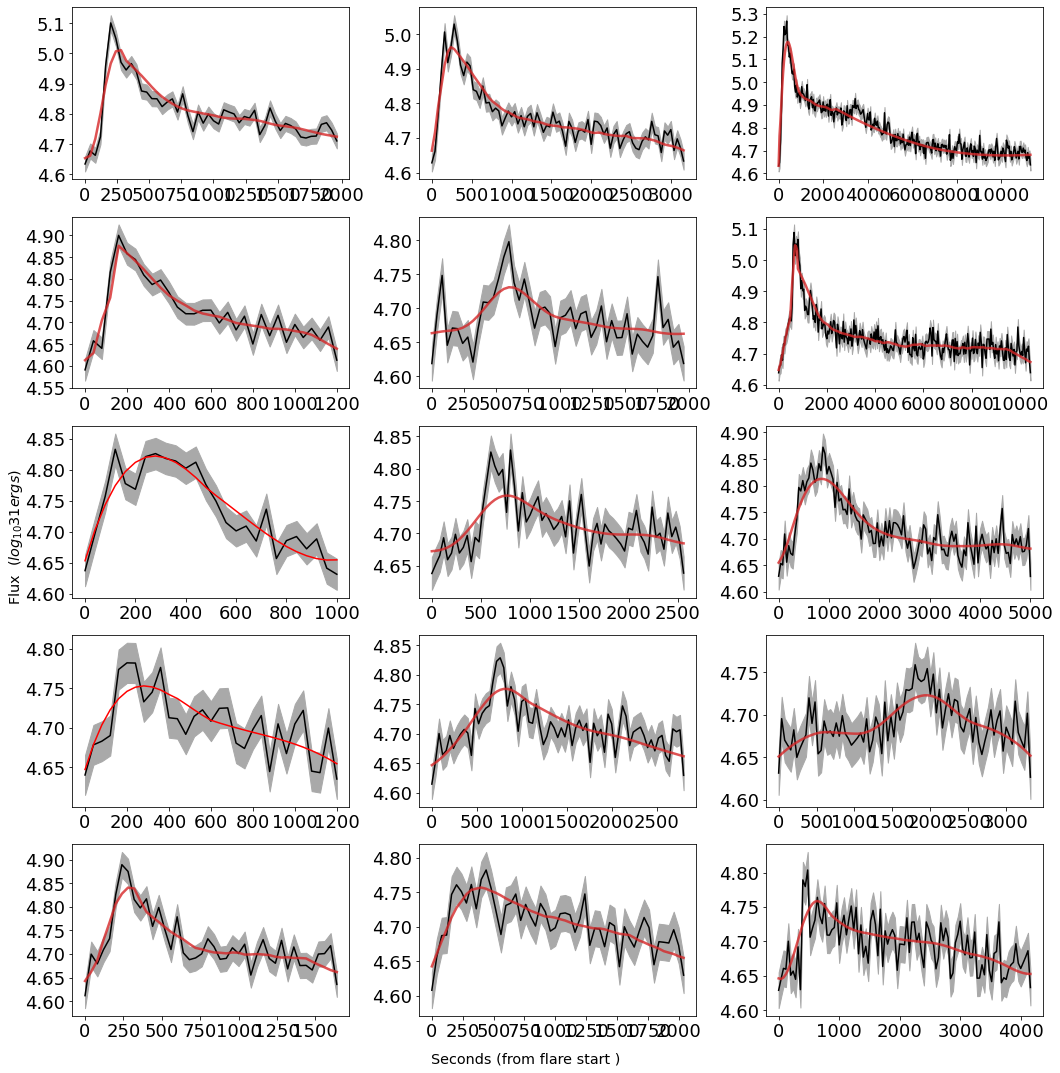

In [63]:
fig,((ax1,ax2,ax3),(ax4,ax5,
     ax6),(ax7,ax8,ax9),(ax10,
     ax11,ax12),(ax13,ax14,ax15)) = plt.subplots(nrows=5,ncols=3,figsize=(15,15),tight_layout=True)
plt.rcParams['font.size'] = '10'

ax1.plot(qpp_1[0],np.array(ergs)/(1e31),c='black')
ax1.fill_between(qpp_1[0],(np.array(ergs)-np.array(er))/(1e31),(np.array(ergs)+np.array(er))/(1e31),color='darkgrey')
ax1.plot(qpp_1[0],fit1/(1e31),color='tab:red',linewidth=2.5,alpha=0.8)

ax4.plot(qpp_2[0],np.array(ergs2)/(1e31),c='black')
ax4.fill_between(qpp_2[0],(np.array(ergs2)-np.array(er2))/(1e31),(np.array(ergs2)+np.array(er2))/(1e31),color='darkgrey')
ax4.plot(qpp_2[0],fit2/(1e31),color='tab:red',linewidth=2.5,alpha=0.8)


ax2.plot(qpp_3[0],np.array(ergs3)/(1e31),c='black')
ax2.fill_between(qpp_3[0],(np.array(ergs3)-np.array(er3))/(1e31),(np.array(ergs3)+np.array(er3))/(1e31),color='darkgrey')
ax2.plot(qpp_3[0],fit3/(1e31),color='tab:red',linewidth=2.5,alpha=0.8)

ax3.plot(qpp_4[0],np.array(ergs4)/(1e31),c='black')
ax3.fill_between(qpp_4[0],(np.array(ergs4)-np.array(er4))/(1e31),(np.array(ergs4)+np.array(er4))/(1e31),color='darkgrey')
ax3.plot(qpp_4[0],smooth_4_2/(1e31),color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax5.plot(qpp_5[0],np.array(ergs5)/(1e31),c='black')
ax5.fill_between(qpp_5[0],(np.array(ergs5)-np.array(er5))/(1e31),(np.array(ergs5)+np.array(er5))/(1e31),color='darkgrey')
ax5.plot(qpp_5[0],smooth_5_2/(1e31),color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax7.plot(qpp_6[0],np.array(ergs6)/(1e31),c='black')
ax7.fill_between(qpp_6[0],(np.array(ergs6)-np.array(er6))/(1e31),(np.array(ergs6)+np.array(er6))/(1e31),color='darkgrey')
ax7.plot(qpp_6[0],fit006/(1e31),c='r',zorder=10)

ax10.plot(qpp_7[0],np.array(ergs7)/(1e31),c='black')
ax10.fill_between(qpp_7[0],(np.array(ergs7)-np.array(er7))/(1e31),(np.array(ergs7)+np.array(er7))/(1e31),color='darkgrey')
ax10.plot(qpp_7[0],fit7_1/(1e31),c='r',zorder=10)

ax8.plot(qpp_8[0],np.array(ergs8)/(1e31),c='black')
ax8.fill_between(qpp_8[0],(np.array(ergs8)-np.array(er8))/(1e31),(np.array(ergs8)+np.array(er8))/(1e31),color='darkgrey')
ax8.plot(qpp_8[0],smooth_8_3/(1e31),color='tab:red',zorder=10,alpha=0.8,linewidth=2.5)

ax9.plot(qpp_9[0],np.array(ergs9)/(1e31),c='black')
ax9.fill_between(qpp_9[0],(np.array(ergs9)-np.array(er9))/(1e31),(np.array(ergs9)+np.array(er9))/(1e31),color='darkgrey')
ax9.plot(qpp_9[0],smooth_9_3/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax6.plot(qpp_10[0],np.array(ergs10)/(1e31),c='black')
ax6.fill_between(qpp_10[0],(np.array(ergs10)-np.array(er10))/(1e31),(np.array(ergs10)+np.array(er10))/(1e31),color='darkgrey')
ax6.plot(qpp_10[0],fit10/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax11.plot(qpp_11[0],np.array(ergs11)/(1e31),c='black')
ax11.fill_between(qpp_11[0],(np.array(ergs11)-np.array(er11))/(1e31),(np.array(ergs11)+np.array(er11))/(1e31),color='darkgrey')
ax11.plot(qpp_11[0],fit011/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax12.plot(qpp_12[0],np.array(ergs12)/(1e31),c='black')
ax12.fill_between(qpp_12[0],(np.array(ergs12)-np.array(er12))/(1e31),(np.array(ergs12)+np.array(er12))/(1e31),color='darkgrey')
ax12.plot(qpp_12[0],fit012/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax14.plot(qpp_13[0],np.array(ergs13)/(1e31),c='black')
ax14.fill_between(qpp_13[0],(np.array(ergs13)-np.array(er13))/(1e31),(np.array(ergs13)+np.array(er13))/(1e31),color='darkgrey')
ax14.plot(qpp_13[0],fit13/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax15.plot(qpp_14[0],np.array(ergs14)/(1e31),c='black')
ax15.fill_between(qpp_14[0],(np.array(ergs14)-np.array(er14))/(1e31),(np.array(ergs14)+np.array(er14))/(1e31),color='darkgrey')
ax15.plot(qpp_14[0],fit014/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax13.plot(qpp_15[0],np.array(ergs15)/(1e31),c='black')
ax13.fill_between(qpp_15[0],(np.array(ergs15)-np.array(er15))/(1e31),(np.array(ergs15)+np.array(er15))/(1e31),color='darkgrey')
ax13.plot(qpp_15[0],fit15/(1e31),c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

fig.supylabel('Flux  ($log_{10} 31  ergs$)',fontsize='x-large')
fig.supxlabel('Seconds (from flare start )',fontsize='x-large')

#fig.savefig('final_QPPcurves', dpi=500, bbox_inches="tight", pad_inches=0)

## Mosaic layout based on flare length

fig = plt.figure(layout="constrained",figsize=(16,16))
subfigs = fig.subfigures(1, 3)
ax0= subfigs[0].subplots(5, 2,sharex=True,sharey=True)
ax1 = subfigs[1].subplots(3, 1,sharex=True,sharey=True)
ax2 = subfigs[2].subplots(2,1,sharex=True,sharey=True)

#Fill Small Flares

ax0[0,0].plot(qpp_1[0],ergs,c='black')
ax0[0,0].fill_between(qpp_1[0],np.array(ergs)-np.array(er),np.array(ergs)+np.array(er),color='darkgrey')
ax0[0,0].plot(qpp_1[0],fit1,color='tab:red',linewidth=2.5,alpha=0.8)
ax0[0,1].plot(qpp_3[0],ergs3,c='black')
ax0[0,1].fill_between(qpp_3[0],np.array(ergs3)-np.array(er3),np.array(ergs3)+np.array(er3),color='darkgrey')
ax0[0,1].plot(qpp_3[0],fit3,color='tab:red',linewidth=2.5,alpha=0.8)
ax0[1,-2].plot(qpp_2[0],ergs2,c='black')
ax0[1,-2].fill_between(qpp_2[0],np.array(ergs2)-np.array(er2),np.array(ergs2)+np.array(er2),color='darkgrey')
ax0[1,-2].plot(qpp_2[0],fit2,color='tab:red',linewidth=2.5,alpha=0.8)
ax0[1,1].plot(qpp_5[0],ergs5,c='black')
ax0[1,1].fill_between(qpp_5[0],np.array(ergs5)-np.array(er5),np.array(ergs5)+np.array(er5),color='darkgrey')
ax0[1,1].plot(qpp_5[0],smooth_5_2,color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)
ax0[2,0].plot(qpp_6[0],ergs6,c='black')
ax0[2,0].fill_between(qpp_6[0],np.array(ergs6)-np.array(er6),np.array(ergs6)+np.array(er6),color='darkgrey')
ax0[2,0].plot(qpp_6[0],fit006,c='r',zorder=10)
ax0[2,-1].plot(qpp_8[0],ergs8,c='black')
ax0[2,-1].fill_between(qpp_8[0],np.array(ergs8)-np.array(er8),np.array(ergs8)+np.array(er8),color='darkgrey')
ax0[2,-1].plot(qpp_8[0],smooth_8_3,color='tab:red',zorder=10,alpha=0.8,linewidth=2.5)
ax0[-2,0].plot(qpp_7[0],ergs7,c='black')
ax0[-2,0].fill_between(qpp_7[0],np.array(ergs7)-np.array(er7),np.array(ergs7)+np.array(er7),color='darkgrey')
ax0[-2,0].plot(qpp_7[0],fit7_1,c='r',zorder=10)
ax0[-2,1].plot(qpp_11[0],ergs11,c='black')
ax0[-2,1].fill_between(qpp_11[0],np.array(ergs11)-np.array(er11),np.array(ergs11)+np.array(er11),color='darkgrey')
ax0[-2,1].plot(qpp_11[0],fit011,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)
ax0[-1,-2].errorbar(qpp_15[0],ergs15,c='black')
ax0[-1,-2].fill_between(qpp_15[0],np.array(ergs15)-np.array(er15),np.array(ergs15)+np.array(er15),color='darkgrey')
ax0[-1,-2].plot(qpp_15[0],fit15,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)
ax0[-1,1].plot(qpp_13[0],ergs13,c='black')
ax0[-1,1].fill_between(qpp_13[0],np.array(ergs13)-np.array(er13),np.array(ergs13)+np.array(er13),color='darkgrey')
ax0[-1,1].plot(qpp_13[0],fit13,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#Fill Medium Flares
ax1[0].plot(qpp_9[0],ergs9,c='black')
ax1[0].fill_between(qpp_9[0],np.array(ergs9)-np.array(er9),np.array(ergs9)+np.array(er9),color='darkgrey')
ax1[0].plot(qpp_9[0],smooth_9_3,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)
ax1[1].plot(qpp_12[0],ergs12,c='black')
ax1[1].fill_between(qpp_12[0],np.array(ergs12)-np.array(er12),np.array(ergs12)+np.array(er12),color='darkgrey')
ax1[1].plot(qpp_12[0],fit012,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)
ax1[2].plot(qpp_14[0],ergs14,c='black')
ax1[2].fill_between(qpp_14[0],np.array(ergs14)-np.array(er14),np.array(ergs14)+np.array(er14),color='darkgrey')
ax1[2].plot(qpp_14[0],fit014,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#Fill Large Flares

ax2[0].plot(qpp_4[0],ergs4,c='black')
ax2[0].fill_between(qpp_4[0],np.array(ergs4)-np.array(er4),np.array(ergs4)+np.array(er4),color='darkgrey')
ax2[0].plot(qpp_4[0],smooth_4_2,color='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

ax2[1].plot(qpp_10[0],ergs10,c='black')
ax2[1].fill_between(qpp_10[0],np.array(ergs10)-np.array(er10),np.array(ergs10)+np.array(er10),color='darkgrey')
ax2[1].plot(qpp_10[0],fit10,c='tab:red',zorder=10,linewidth=2.5,alpha=0.8)

#subfigs[0].suptitle('subfigs[0]\nLeft side')
fig.supylabel('Flux ($erg·sec^{-1}cm^{-2}Å^{-1}$)',fontsize='medium')
fig.supxlabel('Time (seconds)',fontsize='medium')

#subfigs[1].suptitle('subfigs[1]')
#subfigs[1].supylabel('ylabel for subfigs[1]')

#fig.savefig('draft_QPPcurves_mosaic', dpi=500, bbox_inches="tight", pad_inches=0)

## 